In [2]:
import scipy.io as scio
import spectral 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F
import torch.optim as optim
plt.rcParams['font.sans-serif'] = ['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus'] = False   #这两行需要手动设置
data_path = './数据集/Indian_pines/Indian_pines_corrected.mat'
label_path = './数据集/Indian_pines/Indian_pines_gt.mat'
data = scio.loadmat(data_path)
label = scio.loadmat(label_path)   # 读取数据

x = data['indian_pines_corrected']
y = label['indian_pines_gt']
show_x = x.copy()
show_y = y.copy()

'''print(x.shape) # 处理数据为145*145*200,通道数为200,单张像素为145✖145
print(y.shape) # '''

x_list = []
for i in range(145):
    for j in range(145):
        temp = (x[i,j,:]-np.min(x[i,j,:]))/(np.max(x[i,j,:])-np.min(x[i,j,:]))
        x_list.append(temp)

x = np.array(x_list)
y = y.reshape((21025,))

print(x.shape, y.shape)

(21025, 200) (21025,)


In [3]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(np.shape(x_train))
print(np.shape(y_train))

(16820, 200)
(16820,)


In [4]:
#制作数据集
batch_size=32
train_dataset = Data.TensorDataset(torch.tensor(x_train,dtype=torch.float), torch.tensor(y_train,dtype=torch.float))
train_loader = Data.DataLoader(
    dataset=train_dataset,      # 数据，封装进Data.TensorDataset()类的数据
    batch_size=batch_size,      # 每块的大小,即一次训练所抓取的数据样本数量
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
)
test_dataset = Data.TensorDataset(torch.tensor(x_test,dtype=torch.float), torch.tensor(y_test,dtype=torch.float))
test_loader = Data.DataLoader(
    dataset=train_dataset,      # 数据，封装进Data.TensorDataset()类的数据
    batch_size=batch_size,      # 每块的大小
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(200, 6, 1) # 使用1✖1的卷积核，但是通道数减少，可以实现降维
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 1) # 通道数input为6，而output为16，实现升维
        self.fc1 = nn.Linear(16*1*1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 17)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # F.relu(),激活函数
        x = F.relu(self.conv2(x)) 
        x = x.view(-1, 16*1*1) # x.view()相当于numpy.reshape(),(-1,a)表示为行数不确定
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
# 将数据送到GPU中计算
net = Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:{}可用'.format(device))
model = net.to(device) # 将模型放到CUDA中

# 设置损失函数
criterion = nn.CrossEntropyLoss().to(device)
# 构建优化器
# print(list(model.parameters()))
optimizer = optim.Adam(model.parameters(), lr=1e-3)


device:cuda可用


In [6]:
# Training
model.train()
LOSS_list=[]
for epoch in range(150):
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        batch_x = batch_x.reshape((len(batch_x),-1,1,1))
        pred = model(batch_x)
        loss = criterion(pred, batch_y.long())
        LOSS_list.append(loss)
        if (epoch + 1) % 10 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))
        #清除之前的梯度
        optimizer.zero_grad()
        #反向传播计算表梯度
        loss.backward()
        #利用优化器的方法更新参数
        optimizer.step()

Epoch: 0010 loss = 1.288843
Epoch: 0010 loss = 1.087332
Epoch: 0010 loss = 1.294638
Epoch: 0010 loss = 1.008909
Epoch: 0010 loss = 0.917349
Epoch: 0010 loss = 1.282418
Epoch: 0010 loss = 1.055103
Epoch: 0010 loss = 0.762055
Epoch: 0010 loss = 1.299878
Epoch: 0010 loss = 1.122989
Epoch: 0010 loss = 1.357372
Epoch: 0010 loss = 1.273792
Epoch: 0010 loss = 1.285811
Epoch: 0010 loss = 1.235983
Epoch: 0010 loss = 1.254476
Epoch: 0010 loss = 1.203888
Epoch: 0010 loss = 1.115750
Epoch: 0010 loss = 1.171010
Epoch: 0010 loss = 1.299770
Epoch: 0010 loss = 0.878800
Epoch: 0010 loss = 1.248423
Epoch: 0010 loss = 1.043271
Epoch: 0010 loss = 0.947699
Epoch: 0010 loss = 1.795233
Epoch: 0010 loss = 1.592247
Epoch: 0010 loss = 1.119880
Epoch: 0010 loss = 0.856483
Epoch: 0010 loss = 1.140709
Epoch: 0010 loss = 1.109159
Epoch: 0010 loss = 1.111317
Epoch: 0010 loss = 1.221912
Epoch: 0010 loss = 1.085912
Epoch: 0010 loss = 1.154444
Epoch: 0010 loss = 1.158157
Epoch: 0010 loss = 1.504553
Epoch: 0010 loss = 1

In [20]:
#model test

model.eval()
test_loss = 0
correct = 0
target_list = []
pred_list = []
test_acc_list = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        target_list.append(target.cpu().numpy())

        data = data.reshape((len(data),-1,1,1))
        output = model(data)
        pred = output.max(1, keepdim=True)[1]                           # 找到概率最大的下标
        pred_list.append(pred.reshape((len(pred),)).cpu().numpy())


        correct += pred.eq(target.view_as(pred)).sum().item()


test_acc_list.append(100. * correct / len(test_loader.dataset))
print('精度为:({:.0f}%)\n'.format(100. * correct / len(test_loader.dataset)))

精度为:(58%)



In [21]:
tt = []
pp = []
for i in target_list:
    for j in i:
        tt.append(j)
        
for i in pred_list:
    for j in i:
        pp.append(j)

In [22]:
import sklearn
ka = sklearn.metrics.cohen_kappa_score(tt, pp)
print('kappa系数为：',ka)

kappa系数为： 0.3019941138942348


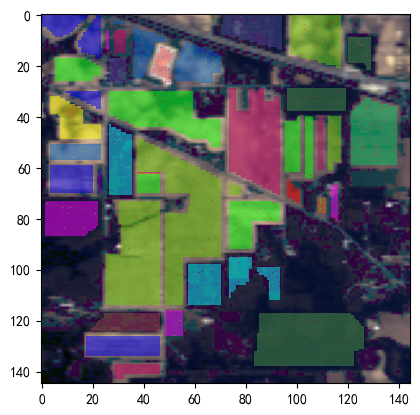

In [23]:
view = spectral.imshow(show_x, (30, 20, 10), classes=show_y)
view.set_display_mode('overlay')
view.class_alpha = 0.5